In [1]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn import preprocessing, metrics
import sklearn as skl
import xgboost
import math
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

In [2]:
# XGBOOST, feature importances
data = pd.read_csv("data/train_data.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11946 entries, 0 to 11945
Data columns (total 40 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   BBLE                      11946 non-null  object 
 1   BORO                      11946 non-null  int64  
 2   BLOCK                     11946 non-null  int64  
 3   LOT                       11946 non-null  int64  
 4   EASEMENT                  126 non-null    object 
 5   OWNER                     11672 non-null  object 
 6   BLDGCL                    11946 non-null  object 
 7   TAXCLASS                  11946 non-null  object 
 8   LTFRONT                   11946 non-null  int64  
 9   LTDEPTH                   11946 non-null  int64  
 10  EXT                       2982 non-null   object 
 11  STORIES                   11235 non-null  float64
 12  FULLVAL                   11946 non-null  int64  
 13  AVLAND                    11946 non-null  int64  
 14  AVTOT 

In [3]:
# GEOGRAFICZNIE UZUPELNIAMY NA PODSTAWIE BLOKÓW
# geograficzne to:staddr, postcode, latitude, longitude, community board
# council district, census tract, NTA
# STORIES - BIERZEMY SREDNIA Z BLOKOW
# ext na dwie kolumny e i g
# EASEMENT - DWIE KOLUMNY E I N
# obliczyc powierzchnie i normalizować

In [4]:
def calc_average_from_block(dataset, block, column):
    new_df = dataset[dataset["BLOCK"] == block]
    return new_df[column].mean()

def calc_postal_code(data, block, column): # postcode, community board, council district, census tract
    new_df = data[data["BLOCK"] == block]
    return max(new_df[column].unique())

def calc_district(data, block, column):
    new_df = data[data["BLOCK"] == block]
    return new_df[column].unique()[0]

In [30]:
def prepare_data(data):
    data.drop(labels=["BBLE", "LOT","PERIOD", "VALTYPE",
                  "Borough", "New Georeferenced Column",
                  "OWNER", "BIN", "EXCD1", "EXCD2",
                  "EXMPTCL", "YEAR", "STADDR"],axis=1, inplace=True)
    data["EASEMENT"] = data["EASEMENT"].fillna("0")
    data["EXT"] = data["EXT"].fillna("0")
    data["EXLAND2"] = data["EXLAND2"].fillna(0)
    data["EXTOT2"] = data["EXTOT2"].fillna(0)
    data["AVLAND2"] = data["AVLAND2"].fillna(0)
    data["AVTOT2"] = data["AVTOT2"].fillna(0)
    data.loc[(data["EASEMENT"] == "F"), "EASEMENT"] = "E"
    data.loc[(data["EASEMENT"] == "G"), "EASEMENT"] = "E"
    data.loc[(data["EASEMENT"] == "H"), "EASEMENT"] = "E"
    data.loc[(data["EASEMENT"] == "I"), "EASEMENT"] = "E"
    data["EXT_E"] = 0
    data["EXT_G"] = 0
    data["EASEMENT_E"] = 0
    data["EASEMENT_N"] = 0
    data.loc[(data["EXT"] == "E"), "EXT_E"] = 1
    data.loc[(data["EXT"] == "EG"), "EXT_E"] = 1
    data.loc[(data["EXT"] == "G"), "EXT_G"] = 1
    data.loc[(data["EXT"] == "EG"), "EXT_G"] = 1
    data.loc[(data["EASEMENT"] == "E"), "EASEMENT_E"] = 1
    data.loc[(data["EASEMENT"] == "N"), "EASEMENT_N"] = 1
    data.drop(["EXT", "EASEMENT"], axis=1, inplace=True)
    data["STORIES"].fillna(method="ffill", inplace=True)
    data["POSTCODE"].loc[data["POSTCODE"].isnull()] = calc_postal_code(data, data["BLOCK"], "POSTCODE")
    data["Community Board"].loc[data["Community Board"].isnull()] = calc_postal_code(data, data["BLOCK"], "Community Board")
    data["Council District"].loc[data["Council District"].isnull()] = calc_postal_code(data, data["BLOCK"], "Council District")
    data["Census Tract"].loc[data["Census Tract"].isnull()] = calc_postal_code(data, data["BLOCK"], "Census Tract")
    data["NTA"].loc[data["NTA"].isnull()] = calc_district(data, data["BLOCK"], "NTA")
    data["Latitude"].loc[data["Latitude"].isnull()] = calc_average_from_block(data, data["BLOCK"], "Latitude")
    data["Longitude"].loc[data["Longitude"].isnull()] = calc_average_from_block(data, data["BLOCK"], "Longitude")
    data["STORIES"].loc[data["STORIES"].isnull()] = calc_average_from_block(data, data["BLOCK"], "STORIES")
    data = data.loc[data["FULLVAL"] != 0]
    
    le = preprocessing.OneHotEncoder()
#     encoded_fit = le.fit_transform(data.BLDGCL.values.reshape(-1,1))
#     encoded_fit.toarray()
#     dummies = pd.get_dummies(data[["BLDGCL"]])
#     data = pd.concat([data, dummies], axis = 1)
    
    encoded_fit = le.fit_transform(data.NTA.values.reshape(-1,1))
    encoded_fit.toarray()
    dummies = pd.get_dummies(data[["NTA"]])
    data = pd.concat([data, dummies], axis = 1)
    
    encoded_fit = le.fit_transform(data.TAXCLASS.values.reshape(-1,1))
    encoded_fit.toarray()
    dummies = pd.get_dummies(data[["TAXCLASS"]])
    data = pd.concat([data, dummies], axis = 1)
    
#     encoded_fit = le.fit_transform(data.POSTCODE.values.reshape(-1,1))
#     encoded_fit.toarray()
#     dummies = pd.get_dummies(data[["POSTCODE"]])
#     data = pd.concat([data, dummies], axis = 1)
    
    data.drop(labels=["NTA","TAXCLASS"] ,axis=1, inplace=True)
    
    le = preprocessing.LabelEncoder()
    le.fit(data['BLDGCL'])
    data.BLDGCL = le.transform(data.BLDGCL)
#     le.fit(data['NTA'])
#     data.NTA = le.transform(data.NTA)
#     le.fit(data['TAXCLASS'])
#     data.TAXCLASS = le.transform(data.TAXCLASS)
#     le.fit(data['POSTCODE'])
#     data.POSTCODE = le.transform(data.POSTCODE)
    
    sc = MinMaxScaler()
    data['Latitude'] = sc.fit_transform(data['Latitude'].values.reshape(-1,1))
    data['Longitude'] = sc.fit_transform(data['Longitude'].values.reshape(-1,1))
    data['LTFRONT'] = sc.fit_transform(data['LTFRONT'].values.reshape(-1,1))
    data['LTDEPTH'] = sc.fit_transform(data['LTDEPTH'].values.reshape(-1,1))
    data['BLDDEPTH'] = sc.fit_transform(data['BLDDEPTH'].values.reshape(-1,1))
    data['BLDFRONT'] = sc.fit_transform(data['BLDFRONT'].values.reshape(-1,1))
#     data['AVLAND'] = sc.fit_transform(data['AVLAND'].values.reshape(-1,1))
#     data['AVTOT'] = sc.fit_transform(data['AVTOT'].values.reshape(-1,1))
#     data['EXLAND'] = sc.fit_transform(data['EXLAND'].values.reshape(-1,1))
#     data['EXTOT'] = sc.fit_transform(data['EXTOT'].values.reshape(-1,1))
#     data["AVLAND"] = np.log10(data["AVLAND"].loc[data["AVLAND"] != 0])
#     data["AVTOT"] = np.log10(data["AVTOT"].loc[data["AVTOT"] != 0])
#     data["EXLAND"] = np.log10(data["EXLAND"].loc[data["EXLAND"] != 0])
#     data["EXTOT"] = np.log10(data["EXTOT"].loc[data["EXTOT"] != 0])
    data.drop(labels=["BLOCK", "POSTCODE"],axis=1, inplace=True)
    return data

In [6]:
def divide_data(data):
    X = data.loc[:, data.columns != 'FULLVAL']
    y = data["FULLVAL"]
    return X, y

In [7]:
def train_test(data):
    train, test = skl.model_selection.train_test_split(data, test_size=25)
    X_train, y_train = divide_data(train)
    X_test, y_test = divide_data(test)
    return X_train, y_train, X_test, y_test

In [8]:
def train_model(X_train, y_train):
    model = xgboost.XGBRegressor(n_estimators=1000, max_depth=9, learning_rate = 0.01,
                         eta=0.1, subsample=0.7, colsample_bytree=0.7)
    model.fit(X_train, y_train)
    return model

In [9]:
def save_model(X_train, y_train):
    model = xgboost.XGBRegressor(n_estimators=1000, max_depth=9, learning_rate = 0.01,
                         eta=0.1, subsample=0.7, colsample_bytree=0.7)
    model.fit(X_train, y_train)
    model.save_model('model.json')

In [31]:
data = pd.read_csv("data/train_data.csv")
data = prepare_data(data)
X, y = divide_data(data)
save_model(X, y)

/home/szaryvip/.local/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [24]:
def best_params_xgb():
    params = { 'max_depth': [5,7,9],
               'learning_rate': [0.01, 0.05, 0.1],
               'n_estimators': [1000],
               'colsample_bytree': [0.7],
               'eta': [0.1, 0.3, 0.5]}
    xgbr = xgboost.XGBRegressor(seed = 20)
    clf = GridSearchCV(estimator=xgbr, 
                       param_grid=params,
                       scoring='neg_mean_squared_error', 
                       verbose=1)
    clf.fit(X, y)
    print("Best parameters:", clf.best_params_)
    print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))

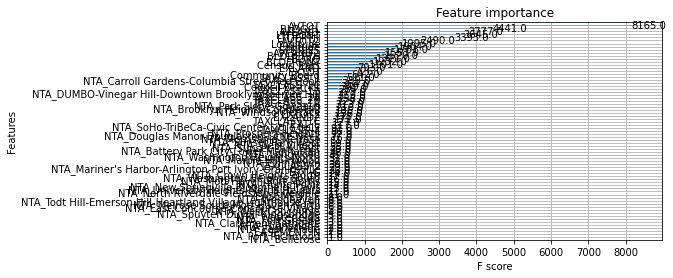

In [12]:
model = xgboost.XGBRegressor()
model.load_model('model.json')
# col = data.loc[:,data.columns != 'FULLVAL'].columns.values.tolist()
# # plt.bar(col, model.feature_importances_)
xgboost.plot_importance(model)
plt.show()

# data.describe()

In [26]:
y = []
for _ in range(20):
    X_train, y_train, X_test, y_test = train_test(data)
    model = train_model(X_train, y_train)
    predictions = model.predict(X_test)
    y.append(metrics.mean_absolute_error(predictions, y_test))
sum(y)/len(y)

122106.43595166018

In [27]:
np.std(y)

184015.18868760963

In [15]:
def best_bldgcl(model, classes, data_row):
    current_value = data_row["FULLVAL"]
    predictions_for_cl = {}
    for cl in classes:
        data_row["BLDGCL"] = cl
        prediction_for_cl[cl] = model.predict(data_row)
    return max(predictions_for_cl, key=predictions_for_cl.get)
    

In [28]:
data_row = data.loc[2000]
classes = data["BLDGCL"].unique()
print(best_bldgcl(model, classes, data_row))

/home/szaryvip/.local/lib/python3.9/site-packages/pandas/core/series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()


ValueError: training data did not have the following fields: BORO, BLDGCL, LTFRONT, LTDEPTH, STORIES, AVLAND, AVTOT, EXLAND, EXTOT, BLDFRONT, BLDDEPTH, AVLAND2, AVTOT2, EXLAND2, EXTOT2, Latitude, Longitude, Community Board, Council District, Census Tract, EXT_E, EXT_G, EASEMENT_E, EASEMENT_N, NTA_Battery Park City-Lower Manhattan, NTA_Bellerose, NTA_Brooklyn Heights-Cobble Hill, NTA_Carroll Gardens-Columbia Street-Red Hook, NTA_Chinatown, NTA_Claremont-Bathgate, NTA_Crotona Park East, NTA_Crown Heights North, NTA_DUMBO-Vinegar Hill-Downtown Brooklyn-Boerum Hill, NTA_Douglas Manor-Douglaston-Little Neck, NTA_East Concourse-Concourse Village, NTA_East Village, NTA_Fort Greene, NTA_Glen Oaks-Floral Park-New Hyde Park, NTA_Highbridge, NTA_Hunts Point, NTA_Longwood, NTA_Lower East Side, NTA_Marble Hill-Inwood, NTA_Mariner's Harbor-Arlington-Port Ivory-Graniteville, NTA_Melrose South-Mott Haven North, NTA_Morrisania-Melrose, NTA_Mott Haven-Port Morris, NTA_Mount Hope, NTA_New Springville-Bloomfield-Travis, NTA_North Riverdale-Fieldston-Riverdale, NTA_Park Slope-Gowanus, NTA_Port Richmond, NTA_Prospect Heights, NTA_SoHo-TriBeCa-Civic Center-Little Italy, NTA_Spuyten Duyvil-Kingsbridge, NTA_Stapleton-Rosebank, NTA_Sunset Park East, NTA_Sunset Park West, NTA_Todt Hill-Emerson Hill-Heartland Village-Lighthouse Hill, NTA_University Heights-Morris Heights, NTA_Washington Heights North, NTA_Washington Heights South, NTA_West Concourse, NTA_West Village, NTA_Westerleigh, NTA_Windsor Terrace, NTA_Woodhaven, NTA_park-cemetery-etc-Manhattan, TAXCLASS_1, TAXCLASS_1A, TAXCLASS_1B, TAXCLASS_1C, TAXCLASS_2, TAXCLASS_2A, TAXCLASS_2B, TAXCLASS_2C, TAXCLASS_4